<a href="https://colab.research.google.com/github/Kaiziferr/Deep_Learning_Workshop/blob/master/multilayer_perceptron/02_workshop_parameter_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import metrics

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/Kaiziferr/Deep_Learning_Workshop/master/workshop_keras_sklearn_introduction/diabetes.csv')
data_values = data.values

In [3]:
def create_base_model():
  model = Sequential()
  model.add(Dense(12, input_dim = 8, activation='relu', kernel_initializer='glorot_uniform'))
  model.add(Dense(8, activation='relu', kernel_initializer='glorot_uniform'))
  model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
  model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  return model

# Data Split

In [4]:
X = data_values[:,0:8]
y = data_values[:,8]

# Houldot

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, shuffle = True, stratify = y)

# Wrapper

In [6]:
model = KerasClassifier(build_fn=create_base_model, epochs = 150, batch_size = 10, verbose = 0)

kfold = StratifiedKFold(n_splits=10, shuffle=True)
result = cross_val_score(model, X, y, cv = kfold)

In [7]:
result

array([0.63636363, 0.63636363, 0.75324672, 0.64935064, 0.70129871,
       0.8051948 , 0.67532468, 0.8051948 , 0.71052629, 0.81578946])

In [8]:
result.mean() , result.std()

(0.7188653349876404, 0.06797145631641796)

# Optimización de hiperparametros

In [16]:
def create_model_optimizer(optimizer = 'rmsprop', init = 'glorot_uniform'):
  model = Sequential()
  model.add(Dense(12, input_dim = 8, kernel_initializer=init, activation='relu'))
  model.add(Dense(8, kernel_initializer=init, activation='relu'))
  model.add(Dense(1, kernel_initializer=init, activation='relu'))
  model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
  return model

In [17]:
model = KerasClassifier(build_fn=create_model_optimizer, verbose = 0)

In [18]:
optimizer = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50 ,100 ,150]
batch = [5, 10, 20]

param_grid = dict(optimizer = optimizer, epochs = epochs, batch_size = batch, init = init)
grid = GridSearchCV(estimator=model, param_grid=param_grid, refit=True, return_train_score=True, cv = 3)

In [19]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fc75e15f090>,
             iid='deprecated', n_jobs=None,
             param_grid={'batch_size': [5, 10, 20], 'epochs': [50, 100, 150],
                         'init': ['glorot_uniform', 'normal', 'uniform'],
                         'optimizer': ['rmsprop', 'adam']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [22]:
print('Mejor: %f usando %s' % (grid.best_score_, grid.best_params_))

Mejor: 0.763889 usando {'batch_size': 5, 'epochs': 100, 'init': 'normal', 'optimizer': 'adam'}


In [23]:
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, std, param in zip(means, stds, params):
  print('%f (%f) con %r' % (mean, std, param))

0.651042 (0.023677) con {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.657986 (0.030764) con {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.723958 (0.051560) con {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'rmsprop'}
0.720486 (0.053171) con {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'adam'}
0.751736 (0.043437) con {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'rmsprop'}
0.684028 (0.025984) con {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'adam'}
0.475694 (0.113021) con {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.574653 (0.133827) con {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.730903 (0.031346) con {'batch_size': 5, 'epochs': 100, 'init': 'normal', 'optimizer': 'rmsprop'}
0.763889 (0.034373) con {'batch_size': 5, 'epochs': 100, 'init': 'normal', 'optimizer': 'adam

In [25]:
model_final = grid.best_estimator_
model_final.get_params()

{'batch_size': 5,
 'build_fn': <function __main__.create_model_optimizer>,
 'epochs': 100,
 'init': 'normal',
 'optimizer': 'adam',
 'verbose': 0}

# Prediccion

In [26]:
"""
@Description: Implement a matrix of confusion of a binary model
@Values:
          validation (Series) a series with values of test
          prediction (Series) a series with values of prediction
          title (String)  title
          target (String)
          not_target (String)
"""

def matrix_confusion(validation, prediction, title, target, not_target):
  matrix = metrics.confusion_matrix(validation, prediction)
  fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))
  sns.heatmap(matrix, annot=True, ax = ax,cmap=plt.cm.Blues,fmt='g',annot_kws={"size": 13})
  ax.set_title(title,size=13)

  ax.xaxis.set_ticklabels([not_target,target])
  ax.yaxis.set_ticklabels([not_target,target], va="center")

  ax.tick_params(labelsize = 13)

  return matrix

In [27]:
"""
@Description: This method show some metrics for algorithms of classification binary
@Values:
          - validation (Series) a series with values of test
          - prediction (Series) a series with values of prediction
          - name_target (Serie) 
          - label: target
          - matrix (ndarray)
"""

def metrics_clasification_binary(validation, prediction, name_target,label, matrix):
  print('Accuracy', metrics.accuracy_score(validation, prediction))
  print('Kappa',  metrics.cohen_kappa_score(validation, prediction))
  print('----------------------------------------------------------- \n')

  print(f'Metrics of {name_target}')
  print('Precision', metrics.precision_score(validation, prediction, label, average='macro'))
  print("Recall: ",  metrics.recall_score(validation, prediction, label, average='macro'))
  
  VN = matrix[0,0]
  FP = matrix[0,1]
  specificity = VN/(VN+FP)

  print('Specificity', specificity)
  print("F1-score      : ", metrics.f1_score(validation, prediction, label, average='macro'))

In [28]:
y_pred = model_final.predict(X_train)

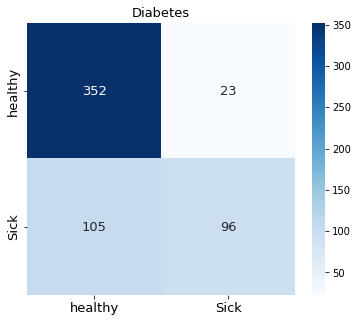

In [32]:
# MAtrix confusion
matrix = matrix_confusion(y_train, y_pred, 'Diabetes' , 'Sick', 'healthy')

In [33]:
metrics_clasification_binary(y_train, y_pred, 'Diabetes',[1], matrix)

Accuracy 0.7777777777777778
Kappa 0.4597968962940169
----------------------------------------------------------- 

Metrics of Diabetes
Precision 0.8067226890756303
Recall:  0.47761194029850745
Specificity 0.9386666666666666
F1-score      :  0.6


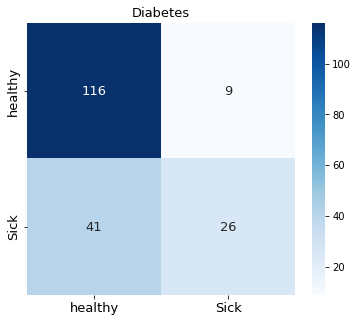

In [35]:
# Datos de test
y_pred = model_final.predict(X_test)
matrix = matrix_confusion(y_test, y_pred, 'Diabetes' , 'Sick', 'healthy')

In [36]:
metrics_clasification_binary(y_test, y_pred, 'Diabetes',[1], matrix)

Accuracy 0.7395833333333334
Kappa 0.3554451456962535
----------------------------------------------------------- 

Metrics of Diabetes
Precision 0.7428571428571429
Recall:  0.3880597014925373
Specificity 0.928
F1-score      :  0.5098039215686275


El modelo empero,en comparación al ejercicio pasado. La sensibilidad se redujo 